This demo will walk through two networks - a bi-directional LSTM and a temporal CNN. The bi-directional LSTM is trained with a pre-trained embedding as well as learning an embedding on its own. All of the networks are overfitting in the examples primarily due to the dataset being used. 
The dataset is the Ditigal Music reviews from: http://jmcauley.ucsd.edu/data/amazon/
We are taking the most positive and most negative reviews from that dataset, and using simple normalization techniques. More complex techniques and larger datasets can be applied to get better results.
The pre-trained word embedding is Google News' 300d vector which can be downloaded from https://code.google.com/archive/p/word2vec/

Everything can be run on a laptop, Python 3.6 is used, though it should all work in Python 2.7 as well.

In [101]:
import numpy as np
import pandas as pd 
import pickle
import json
import gensim
import os
import re

from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, Bidirectional, LSTM, regularizers
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials

In [146]:
# Change these to match your file paths :)
filename = 'pathy/path/reviews_Digital_Music_5.json' #64,706 reviews

In [17]:
model_path = "model_path/GoogleNews-vectors-negative300.bin"
word_vector_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [174]:
# The results of several hyperopt trials
trials = pickle.load(open('/opt_trials.pkl', 'rb'))

In [132]:
def normalize(txt, vocab=None, replace_char=' ',
                max_length=300, pad_out=False,
                to_lower=True, reverse = False,
                truncate_left=False, encoding=None):
  
    # remove html
    # This will keep characters and other symbols
    txt = txt.split()
    # Remove HTML
    txt = [re.sub(r'http:.*', '', r) for r in txt]
    txt = [re.sub(r'https:.*', '', r) for r in txt]
    
    txt = ( " ".join(txt))
    # Letters only and remove extra whitespaces
    txt = re.sub("[.,!]", " ", txt)
    #txt = re.sub("[^a-zA-Z]", " ", txt)
    txt = " ".join(txt.split())
    # store length for multiple comparisons
    txt_len = len(txt)

    if truncate_left:
        txt = txt[-max_length:]
    else:
        txt = txt[:max_length]
    # change case
    if to_lower:
        txt = txt.lower()
    # Reverse order
    if reverse:
        txt = txt[::-1]
    # replace chars
    if vocab is not None:
        txt = ''.join([c if c in vocab else replace_char for c in txt])
    # re-encode text
    if encoding is not None:
        txt = txt.encode(encoding, errors="ignore")
    # pad out if needed
    if pad_out and max_length>txt_len:
        txt = txt + replace_char * (max_length - txt_len)
    return txt

In [144]:
normalize("This is A sentence. with things :) and a link https://gitub.com")

'this is a sentence with things :) and a link'

In [134]:
def balance(df):
    print("Balancing the classes")
    type_counts = df['Sentiment'].value_counts()
    min_count = min(type_counts.values)

    balanced_df = None
    for key in type_counts.keys():

        df_sub = df[df['Sentiment']==key].sample(n=min_count, replace=False)
        if balanced_df is not None:
            balanced_df = balanced_df.append(df_sub)
        else:
            balanced_df = df_sub
    return balanced_df

Some of the larger Amazon datasts have to be loaded line by line, the smaller may be read directly. I'm also changing the reviews into a sentiment, and only 1 or 5 star reviews, but this function can be modified as desired.

In [135]:
good_columns = [
    "overall", 
    "reviewText", 
    "summary"
]

def review_to_sentiment(review):
    # Review is coming in as overall (the rating, reviewText, and summary)
    # this then cleans the summary and review and gives it a positive or negative value
    norm_text = normalize(review[2] + " " + review[1])
    if review[0] ==5:
        return ['positive', norm_text]
    elif review[0] ==1:
        return ['negative', norm_text]
    else:
        return ['other', norm_text]
    


data = []
with open(filename, 'r') as f:
    for line in f:
        data_line = json.loads(line)
        selected_row = []
        for item in good_columns:
            selected_row.append(data_line[item])
        # as we read in, clean
        data.append(review_to_sentiment(selected_row))
        
amazon = pd.DataFrame(data, columns=['Sentiment', 'clean_text'], dtype=str)



In [136]:
# For this demo lets just keep one and five stars the others are marked 'other
amazon = amazon[amazon['Sentiment'].isin(['positive', 'negative'])]
amazon.head()

,Sentiment,clean_text
0,positive,"enya's last great album it's hard to believe ""..."
1,positive,enya at her most elegant a clasically-styled a...
2,positive,the best so far i never thought enya would rea...
3,positive,ireland produces good music this is the third ...
5,positive,dreamy unearthly magic continues with eire's o...


In [137]:
balanced_amazon = balance(amazon)
len(balanced_amazon)

Balancing the classes


5582

In [138]:
# Now go from the pandas into lists of text and labels

text = balanced_amazon['clean_text'].values
labels_0 = pd.get_dummies(balanced_amazon['Sentiment'])  # mapping of the labels with dummies (has headers)
labels = labels_0.values #removes the headers

In [139]:
# Perform the Train/test split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(text,labels, test_size = 0.2, random_state = 42)

In [140]:
# What does the data look like?
Y_train_[:5]

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [141]:
X_train_[42]

'dan fogelberg\'s masterpiece has just gotten even better i owe a great debt to dan fogelberg; he and specifically his tracks "longer" and "the leader of the band" are what made me interested in picking up the acoustic guitar years back when i was a tween it has been a hobby of mine that has made me l'

In [142]:
### Now for a simple bidirectional LSTM algorithm we set our feature sizes and train a tokenizer
# First we Tokenize and get the data into a form that the model can read - this is BoW

max_fatures = 2000
max_len=300
batch_size = 32
embed_dim = 300
lstm_out = 140

dense_out=len(labels[0]) #length of features
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_)
X_train = tokenizer.texts_to_sequences(X_train_)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')

X_test = tokenizer.texts_to_sequences(X_test_)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

word_index = tokenizer.word_index

In [143]:
# Now what does our data look like?
# Tokenizer creates a BOW encoding, which is then going to be fed into our Embedding matrix
# This will be used by the model to build up a word embedding
X_test[42]

array([  4,   6, 148,   2,  37,   1,  41, 223, 268,  15, 271, 945, 731,
        12,  17,   7, 503,  49,  21,   1,   7, 201, 296, 474, 308,  41,
       308,  70,   6,  33,   3,  40,  41,   1,  41,  13, 523,  54, 540,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [145]:
# What does a word vector look like?
# Ahhhh, like a bunch of numbers
word_vector_model.word_vec('hi')

array([-1.65039062e-01,  2.04101562e-01,  1.30859375e-01,  2.87109375e-01,
       -1.68945312e-01, -3.66210938e-03,  1.72851562e-01, -2.75390625e-01,
       -3.61328125e-02,  3.19824219e-02,  6.34765625e-02, -7.17773438e-02,
       -3.00781250e-01, -7.42187500e-02,  3.12500000e-02,  6.44531250e-02,
        6.54296875e-02,  6.29882812e-02,  1.50390625e-01, -3.06640625e-01,
       -3.97949219e-02, -9.37500000e-02,  1.98974609e-02, -1.44653320e-02,
       -9.66796875e-02, -1.00585938e-01, -2.92968750e-01, -5.59082031e-02,
        4.16015625e-01, -2.22656250e-01,  1.45507812e-01, -3.34472656e-02,
        1.84326172e-02, -1.62109375e-01, -1.12304688e-01, -1.78710938e-01,
       -1.92382812e-01, -7.87353516e-03,  3.32031250e-01,  6.54296875e-02,
       -6.44531250e-02, -1.39648438e-01,  3.84765625e-01,  2.38281250e-01,
       -1.00097656e-01,  1.17675781e-01, -1.16699219e-01, -8.69140625e-02,
        4.66308594e-02,  1.19140625e-01, -2.44140625e-01,  1.45507812e-01,
        2.94921875e-01,  

In [156]:
print('Prepare the embedding matrix')

# prepare embedding matrix
num_words = min(max_fatures, len(word_index))
embedding_matrix = np.zeros((num_words, embed_dim))
for word, i in word_index.items():
    if i >= max_len:
        continue
    # words not found in embedding index will be all-zeros.
    if word in word_vector_model.vocab:
        embedding_matrix[i] = word_vector_model.word_vec(word)

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = True to fine tune the embeddings
embedding_layer = Embedding(num_words,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=max_fatures,
                            trainable=True)

Prepare the embedding matrix


In [18]:
# Define the model using the pre-trained embedding
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(lstm_out, recurrent_dropout=0.5, activation='tanh'))(embedded_sequences)
preds = Dense(dense_out, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Prepare the embedding matrix


In [19]:
model_hist_embedding = model.fit(X_train, Y_train_, epochs = 30, batch_size=batch_size, verbose = 2,
                        validation_data=(X_test,Y_test_))

Train on 4465 samples, validate on 1117 samples
Epoch 1/30
 - 166s - loss: 0.4876 - acc: 0.7709 - val_loss: 0.3507 - val_acc: 0.8630
Epoch 2/30
 - 151s - loss: 0.3083 - acc: 0.8719 - val_loss: 0.3272 - val_acc: 0.8621
Epoch 3/30
 - 150s - loss: 0.2471 - acc: 0.9008 - val_loss: 0.3266 - val_acc: 0.8747
Epoch 4/30
 - 152s - loss: 0.1978 - acc: 0.9232 - val_loss: 0.3568 - val_acc: 0.8756
Epoch 5/30
 - 149s - loss: 0.1685 - acc: 0.9355 - val_loss: 0.3485 - val_acc: 0.8666
Epoch 6/30
 - 150s - loss: 0.1340 - acc: 0.9489 - val_loss: 0.3855 - val_acc: 0.8550
Epoch 7/30
 - 151s - loss: 0.1068 - acc: 0.9577 - val_loss: 0.5617 - val_acc: 0.8585
Epoch 8/30
 - 150s - loss: 0.0808 - acc: 0.9711 - val_loss: 0.4740 - val_acc: 0.8594
Epoch 9/30
 - 152s - loss: 0.0608 - acc: 0.9781 - val_loss: 0.5998 - val_acc: 0.8218
Epoch 10/30
 - 152s - loss: 0.0375 - acc: 0.9895 - val_loss: 0.6441 - val_acc: 0.8496
Epoch 11/30
 - 150s - loss: 0.0233 - acc: 0.9919 - val_loss: 0.7123 - val_acc: 0.8505
Epoch 12/30
 - 

## Hyperparameter Optimization
There are many different parameters with this, one way to optimize is to use Hyperopt: https://github.com/hyperopt/hyperopt
I wrote a blog about using hyperopt a while back to help get others started with the repo https://gab41.lab41.org/effectively-running-thousands-of-experiments-hyperopt-with-sacred-dfa53b50f1ec 

What I found though was that the dataset or model used didn't really change performance much - besides the parameter max_features. I'll likely try this experiment with a larger dataset and different models.

In [105]:
def simple_lstm(max_fatures, dense_out, input_length, embed_dim = 256, lstm_out = 140,
                dropout = 0.5):
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,  input_length = input_length))
    #model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=dropout,activation='tanh')))
    model.add(Dense(dense_out, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

def run_model(args):
    print("Running model")
    print(args)
    # split the data differently each time
    # normally you would also pass in the data through the args
    X_train_, X_test_, Y_train, Y_test = train_test_split(text, labels, test_size = 0.20)

    # Prep data for the LSTM model
    tokenizer = Tokenizer(num_words=int(args['max_features']), split=' ')
    tokenizer.fit_on_texts(text)
    X_train = tokenizer.texts_to_sequences(X_train_)
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = tokenizer.texts_to_sequences(X_test_)
    X_test = pad_sequences(X_test, maxlen=max_len)

    # Train the LSTM model
    lstm_model = simple_lstm(int(args['max_features']), dense_out, X_train.shape[1],
                             int(args['embed_dim']), int(args['lstm_out']), args['dropout'])

    es = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=0, mode='max')
    model_hist = lstm_model.fit(X_train, Y_train, epochs = args['epochs'] +1, batch_size=batch_size,
                                verbose = 1, validation_data=(X_test,Y_test), callbacks=[es])
    lstm_acc = model_hist.history['val_acc'][-1]
    print("LSTM model accuracy ", lstm_acc)
    # Hyperopt minimizes, so the maximize we have to take the inverse
    return 1-lstm_acc



In [106]:
trials_to_keep = Trials()
num_evals = 2
data = {'text':text,
        'labels': labels}

# I was lazy so used uniform with a min/max and then rounded it using int()
space = {'max_features': hp.choice('max_features', [500, 1000, 2000, 3000]),
         'embed_dim': hp.uniform('embed_dim', 100, 500),
         'lstm_out': hp.uniform('lstm_out', 50, 300),
         'epochs': hp.randint('epochs', 50),
         'dropout': hp.uniform('dropout', 0.0, 0.9)}

best = fmin(run_model,
        space,
        algo=tpe.suggest,
        max_evals=num_evals,
        trials = trials_to_keep )

Running model
{'dropout': 0.12202182490461044, 'embed_dim': 308.31258361258045, 'epochs': 3, 'lstm_out': 250.73568177332726, 'max_features': 1000}
Train on 4465 samples, validate on 1117 samples
Epoch 1/3
4465/4465 [==============================] - 246s 55ms/step - loss: 0.5615 - acc: 0.7019 - val_loss: 0.5078 - val_acc: 0.7717
Epoch 2/3
4465/4465 [==============================] - 180s 40ms/step - loss: 0.3547 - acc: 0.8515 - val_loss: 0.3785 - val_acc: 0.8577
Epoch 3/3
4465/4465 [==============================] - 160s 36ms/step - loss: 0.2877 - acc: 0.8896 - val_loss: 0.3836 - val_acc: 0.8478
LSTM model accuracy  0.8478066254750681
Running model
{'dropout': 0.586122265386417, 'embed_dim': 183.88982489952656, 'epochs': 31, 'lstm_out': 173.33434803143382, 'max_features': 1000}
Train on 4465 samples, validate on 1117 samples
Epoch 1/31
4465/4465 [==============================] - 78s 18ms/step - loss: 0.5292 - acc: 0.7205 - val_loss: 0.4232 - val_acc: 0.8165
Epoch 2/31
4465/4465 [=====

In [175]:
# I ran this over a few days to get the following runs

# Max features is a map so we will revise it back
features = [500, 1000, 2000, 3000]
def map_max_features(feature_id):
    return features[feature_id]
results = []
for t in trials.trials:
    results.append([t['tid'], 1-t['result']['loss'], t['misc']['vals']['dropout'][0], 
                    int(t['misc']['vals']['embed_dim'][0]), t['misc']['vals']['epochs'][0], 
                    int(t['misc']['vals']['lstm_out'][0]), map_max_features(t['misc']['vals']['max_features'][0])])

In [176]:
results_df = pd.DataFrame(results, columns=['id', 'accuracy', 'dropout', 'embed_dim', 'epochs', 'lstm_out',
                                           'max_features'])
# There is a bad accuracy result...so removing it (it is a lot worse than average)
results_df = results_df[results_df['accuracy']>0.6]
results_df.head()

,id,accuracy,dropout,embed_dim,epochs,lstm_out,max_features
0,0,0.879204,0.020156,147,36,290,2000
1,1,0.888412,0.093054,425,12,240,3000
2,2,0.831419,0.039036,362,7,288,500
3,3,0.829140,0.062753,416,21,130,500
4,4,0.859472,0.060833,172,32,101,2000


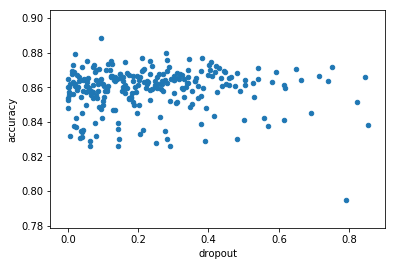

In [177]:
results_df.plot.scatter(x='dropout', y='accuracy');

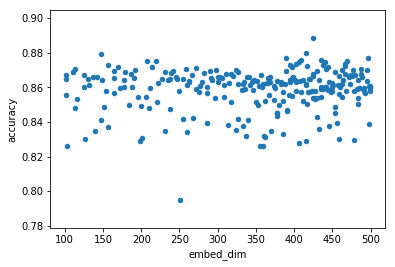

In [178]:
results_df.plot.scatter(x='embed_dim', y='accuracy');

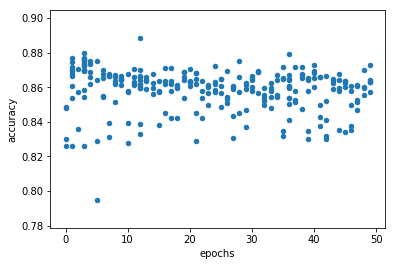

In [179]:
results_df.plot.scatter(x='epochs', y='accuracy');

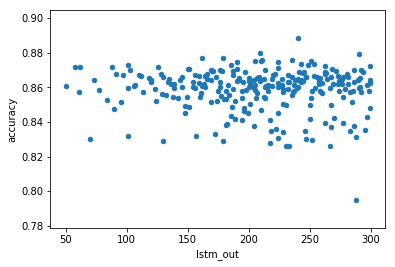

In [180]:
results_df.plot.scatter(x='lstm_out', y='accuracy');

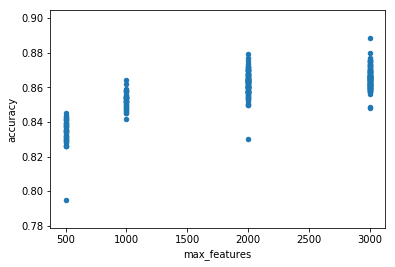

In [181]:
# Of all the features this one has the largest impact
results_df.plot.scatter(x='max_features', y='accuracy');

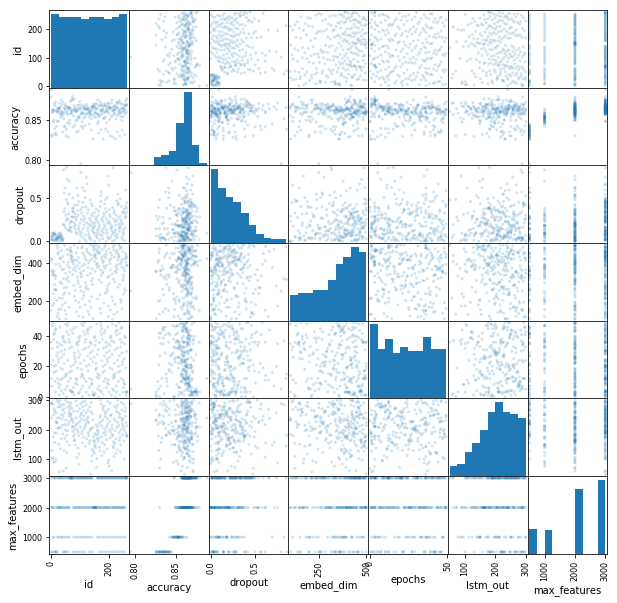

In [182]:


_ = scatter_matrix(results_df, alpha=0.2, figsize=(10, 10), diagonal='hist')

## Temporal Convolutional Networks
How does the simple bidirectional LSTM compare to the temporal convolutional network?

In [22]:
def get_one_hot_doc(txt, replace_vocab=None, replace_char=' ',
                min_length=10, max_length=300, pad_out=True,
                to_lower=True, reverse = True,
                truncate_left=False, encoding=None):

    return to_one_hot(txt)

zhang_lecun_vocab=list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}") #shortened version
vocab_hash = {b: a for a, b in enumerate(zhang_lecun_vocab)}

def to_one_hot(txt, vocab=vocab_hash):
    
    vocab_size = len(vocab.keys())
    one_hot_vec = np.zeros((vocab_size, len(txt)), dtype=np.float32)
    # run through txt and "switch on" relevant positions in one-hot vector
    for idx, char in enumerate(txt):
        try:
            vocab_idx = vocab_hash[char]
            one_hot_vec[vocab_idx, idx] = 1
        # raised if character is out of vocabulary
        except:
            #print(char)
            pass
    return one_hot_vec

In [25]:
get_one_hot_doc("a cat ate foccacia")

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
def one_hot_cnn(dense_out, max_len=300, frame='small'):

    if frame == 'large':
        cnn_size = 1024
        fully_connected = [2048,2048,dense_out]
    elif frame =='small':
        cnn_size = 256
        fully_connected = [1024,1024,dense_out]
    elif frame =='tiny':
        cnn_size = 128
        fully_connected = [512,512,dense_out]
        

    model = Sequential()

    model.add(Conv1D(cnn_size, 7, padding='same', input_shape=(67, max_len)))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 22 x cnn_size
    model.add(Conv1D(cnn_size, 7, padding='same'))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    model.add(Conv1D(cnn_size,3, padding='same'))

    # #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size, 3, padding='same'))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Flatten())

    #Fully Connected Layers

    #Input is 512 Output is 1024/2048
    model.add(Dense(fully_connected[0]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is 1024/2048
    model.add(Dense(fully_connected[1]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is dense_out size (number of classes)
    model.add(Dense(fully_connected[2]))
    model.add(Activation('softmax'))

    #Stochastic gradient parameters as set by paper
    sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [24]:
X_train_a_ = [get_one_hot_doc(x) for x in X_train_]
X_test_a_ = [get_one_hot_doc(x) for x in X_test_]

X_train_a = np.asarray(X_train_a_)
Y_train_a = Y_train_

X_test_a = np.asarray(X_test_a_)
Y_test_a = Y_test_

print(X_train_a.shape)

(4465, 67, 300)


In [28]:
model_cnn = one_hot_cnn(dense_out, frame='small')
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 67, 256)           537856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 22, 256)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 22, 256)           459008    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 7, 256)            196864    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 7, 256)            196864    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 256)            196864    
__________

In [29]:
model_hist_cnn = model_cnn.fit(X_train_a, Y_train_a, batch_size=64, epochs=30, verbose=1, 
          validation_data=(X_test_a,Y_test_a))

Train on 4465 samples, validate on 1117 samples
Epoch 1/30
4465/4465 [==============================] - 11s 3ms/step - loss: 0.7162 - acc: 0.4907 - val_loss: 0.6942 - val_acc: 0.4879
Epoch 2/30
4465/4465 [==============================] - 11s 3ms/step - loss: 0.7035 - acc: 0.5124 - val_loss: 0.6985 - val_acc: 0.4879
Epoch 3/30
4465/4465 [==============================] - 12s 3ms/step - loss: 0.7018 - acc: 0.4972 - val_loss: 0.6931 - val_acc: 0.5121
Epoch 4/30
4465/4465 [==============================] - 12s 3ms/step - loss: 0.6997 - acc: 0.5030 - val_loss: 0.6920 - val_acc: 0.5291
Epoch 5/30
4465/4465 [==============================] - 11s 3ms/step - loss: 0.6934 - acc: 0.5303 - val_loss: 0.7006 - val_acc: 0.4879
Epoch 6/30
4465/4465 [==============================] - 12s 3ms/step - loss: 0.6889 - acc: 0.5400 - val_loss: 0.6905 - val_acc: 0.5192
Epoch 7/30
4465/4465 [==============================] - 11s 3ms/step - loss: 0.6549 - acc: 0.6108 - val_loss: 0.7043 - val_acc: 0.5443
Epoch 8

How do these difference performances compare?

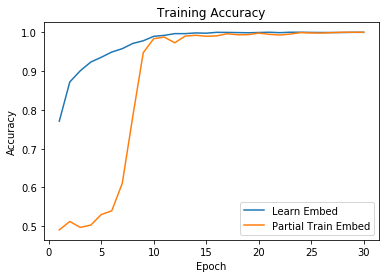

In [157]:
# Training Accuracy
x = np.arange(30)+1

plt.plot(x, model_hist_embedding.history['acc'])
plt.plot(x, model_hist_cnn.history['acc'])
plt.legend(['Learn Embed', 'Partial Train Embed', 'CNN'], loc='lower right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training Accuracy")
plt.show()

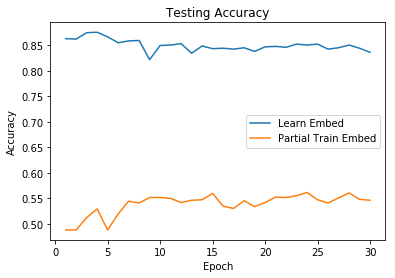

In [158]:
# Testing Accuracy
x = np.arange(30)+1

plt.plot(x, model_hist_embedding.history['val_acc'])
plt.plot(x, model_hist_cnn.history['val_acc'])
plt.legend(['Learn Embed', 'Partial Train Embed', 'CNN'], loc='right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Testing Accuracy")
plt.show()

So Basically they are all overfitting!
This is a small dataset to show what can be done with deep learning